In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'ai2_arc',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist

In [3]:
train_split, valid_split = ['train[:90%]', 'train[90%:]']
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
valid_data = tfds.load("cifar10", split=valid_split)
test_data = tfds.load("cifar10", split="test")

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [5]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
train_dict = {}
for data in train_data:
    label = data['label'].numpy()
    train_dict[label] = train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


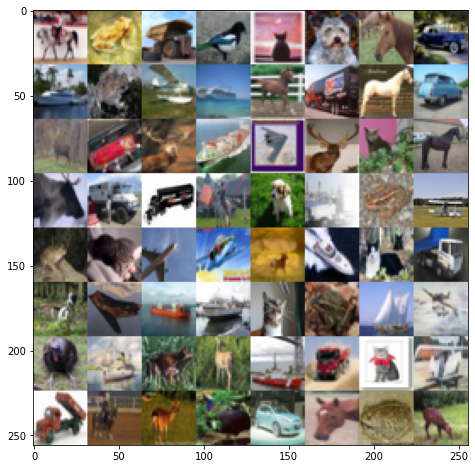

In [7]:
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
for data in train_data.batch(8).take(8):
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
plt.figure(figsize=(8, 8))
plt.imshow(output)

In [8]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 64
train_num = int(info.splits['train'].num_examples / 10) * 9 

train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [10]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x) 

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary() 

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1315

In [11]:
model_dir = 'lab4-logs/models'
os.makedirs(model_dir) 

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'lab4-logs/models'

In [12]:
log_dir = os.path.join('lab4-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir='lab4-logs/model-1')

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [13]:
model_1.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [14]:
history_1 = model_1.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 6s 5ms/step - loss: 2.1773 - categorical_accuracy: 0.1512 - val_loss: 2.0847 - val_categorical_accuracy: 0.1974
Epoch 2/100
704/704 [==============================] - 3s 4ms/step - loss: 2.1108 - categorical_accuracy: 0.1747 - val_loss: 2.0780 - val_categorical_accuracy: 0.2112
Epoch 3/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0947 - categorical_accuracy: 0.1807 - val_loss: 2.0544 - val_categorical_accuracy: 0.2096
Epoch 4/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0825 - categorical_accuracy: 0.1909 - val_loss: 2.0184 - val_categorical_accuracy: 0.2122
Epoch 5/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0628 - categorical_accuracy: 0.1983 - val_loss: 2.0228 - val_categorical_accuracy: 0.2312
Epoch 6/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0423 - categorical_accuracy: 0.2133 - val_loss: 2.0587 - val_categorical_accuracy: 0.206

Epoch 50/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9799 - categorical_accuracy: 0.2396 - val_loss: 1.9832 - val_categorical_accuracy: 0.2458
Epoch 51/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9642 - categorical_accuracy: 0.2458 - val_loss: 1.9973 - val_categorical_accuracy: 0.2368
Epoch 52/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9624 - categorical_accuracy: 0.2439 - val_loss: 1.9644 - val_categorical_accuracy: 0.2588
Epoch 53/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9796 - categorical_accuracy: 0.2393 - val_loss: 1.9920 - val_categorical_accuracy: 0.2458
Epoch 54/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0009 - categorical_accuracy: 0.2332 - val_loss: 2.0061 - val_categorical_accuracy: 0.2498
Epoch 55/100
704/704 [==============================] - 3s 4ms/step - loss: 2.0111 - categorical_accuracy: 0.2311 - val_loss: 2.0150 - val_categorical_accuracy:

Epoch 99/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9793 - categorical_accuracy: 0.2381 - val_loss: 2.0054 - val_categorical_accuracy: 0.2384
Epoch 100/100
704/704 [==============================] - 3s 4ms/step - loss: 1.9879 - categorical_accuracy: 0.2348 - val_loss: 1.9885 - val_categorical_accuracy: 0.2480


In [15]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)loss, acc = model_1.evaluate(test_data)
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 [==============================] - 0s 2ms/step - loss: 1.9900 - categorical_accuracy: 0.2465

Model-1 Accuracy: 0.24650000035762787%


In [16]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          7379

In [17]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [18]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [19]:
history_2 = model_2.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 11s 9ms/step - loss: 1.8740 - categorical_accuracy: 0.2929 - val_loss: 1.5636 - val_categorical_accuracy: 0.4198
Epoch 2/100
704/704 [==============================] - 6s 9ms/step - loss: 1.5462 - categorical_accuracy: 0.4312 - val_loss: 1.3993 - val_categorical_accuracy: 0.4896
Epoch 3/100
704/704 [==============================] - 6s 9ms/step - loss: 1.3724 - categorical_accuracy: 0.5082 - val_loss: 1.2424 - val_categorical_accuracy: 0.5476
Epoch 4/100
704/704 [==============================] - 6s 9ms/step - loss: 1.2414 - categorical_accuracy: 0.5593 - val_loss: 1.0537 - val_categorical_accuracy: 0.6224
Epoch 5/100
704/704 [==============================] - 6s 9ms/step - loss: 1.1377 - categorical_accuracy: 0.5980 - val_loss: 1.1269 - val_categorical_accuracy: 0.6122
Epoch 6/100
704/704 [==============================] - 6s 9ms/step - loss: 1.0564 - categorical_accuracy: 0.6294 - val_loss: 0.9266 - val_categorical_accuracy: 0.66

704/704 [==============================] - 6s 9ms/step - loss: 0.0881 - categorical_accuracy: 0.9750 - val_loss: 2.4593 - val_categorical_accuracy: 0.7366
Epoch 98/100
704/704 [==============================] - 6s 9ms/step - loss: 0.0969 - categorical_accuracy: 0.9733 - val_loss: 2.2035 - val_categorical_accuracy: 0.7408
Epoch 99/100
704/704 [==============================] - 6s 9ms/step - loss: 0.0952 - categorical_accuracy: 0.9738 - val_loss: 2.2260 - val_categorical_accuracy: 0.7422
Epoch 100/100
704/704 [==============================] - 6s 9ms/step - loss: 0.0833 - categorical_accuracy: 0.9764 - val_loss: 2.4464 - val_categorical_accuracy: 0.7392


In [20]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 4ms/step - loss: 2.4919 - categorical_accuracy: 0.7300

Model-2 Accuracy: 0.7300000190734863%


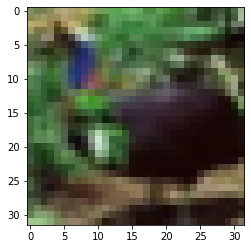

In [21]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

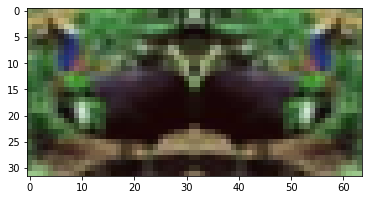

In [22]:
def flip(x):
    
    x = tf.image.random_flip_left_right(x) 
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

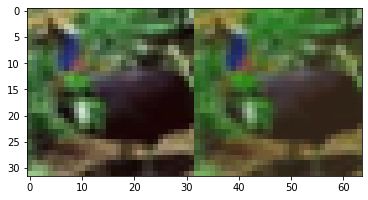

In [23]:
def color(x):
    
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

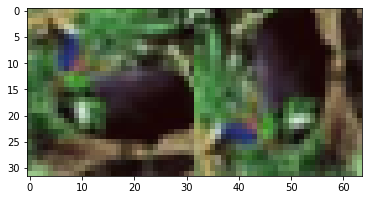

In [24]:
def rotate(x):
    
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

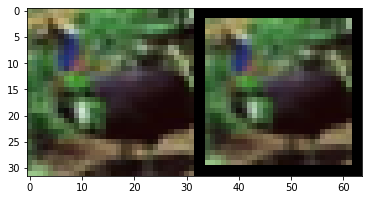

In [25]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max) 
    sh = h * scale 
    sw = w * scale  
    x = tf.image.resize(x, (sh, sw)) 
    x = tf.image.resize_with_crop_or_pad(x, h, w)  
    return x

image_2 = zoom(image_test)

image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  
plt.imshow(image)

In [26]:
train_data = tfds.load("cifar10", split=train_split)

In [27]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255. 
    x = flip(x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [28]:
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

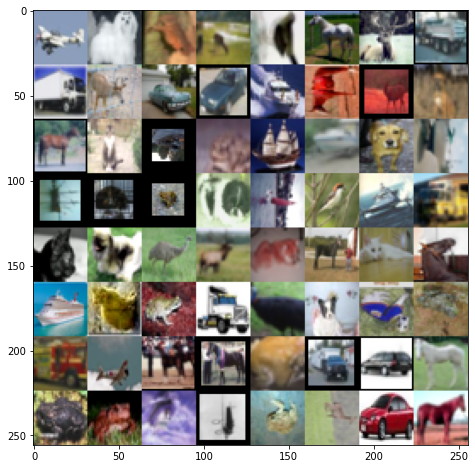

In [29]:
for images, labels in train_data.take(1):
    images = images.numpy()

output = np.zeros((32 * 8, 32 * 8, 3))

for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))

plt.imshow(output)

In [30]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 256)       295168    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 128)         295040    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          7379

In [31]:
log_dir = os.path.join('lab4-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [32]:
model_3.compile(keras.optimizers.Adam(), 
               loss=keras.losses.CategoricalCrossentropy(), 
               metrics=[keras.metrics.CategoricalAccuracy()])

In [33]:
history_3 = model_3.fit(train_data,
                        epochs=100, 
                        validation_data=valid_data,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
704/704 [==============================] - 7s 9ms/step - loss: 2.0476 - categorical_accuracy: 0.2226 - val_loss: 1.7280 - val_categorical_accuracy: 0.3866
Epoch 2/100
704/704 [==============================] - 6s 9ms/step - loss: 1.8373 - categorical_accuracy: 0.3220 - val_loss: 1.5000 - val_categorical_accuracy: 0.4378
Epoch 3/100
704/704 [==============================] - 6s 9ms/step - loss: 1.7143 - categorical_accuracy: 0.3724 - val_loss: 1.4661 - val_categorical_accuracy: 0.4632
Epoch 4/100
704/704 [==============================] - 7s 9ms/step - loss: 1.6127 - categorical_accuracy: 0.4154 - val_loss: 1.2952 - val_categorical_accuracy: 0.5334
Epoch 5/100
704/704 [==============================] - 6s 9ms/step - loss: 1.5475 - categorical_accuracy: 0.4466 - val_loss: 1.1687 - val_categorical_accuracy: 0.5784
Epoch 6/100
704/704 [==============================] - 6s 9ms/step - loss: 1.4798 - categorical_accuracy: 0.4755 - val_loss: 1.1795 - val_categorical_accuracy: 0.586

Epoch 50/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8818 - categorical_accuracy: 0.7039 - val_loss: 0.7097 - val_categorical_accuracy: 0.7686
Epoch 51/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8719 - categorical_accuracy: 0.7060 - val_loss: 0.6602 - val_categorical_accuracy: 0.7752
Epoch 52/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8758 - categorical_accuracy: 0.7060 - val_loss: 0.6538 - val_categorical_accuracy: 0.7802
Epoch 53/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8761 - categorical_accuracy: 0.7096 - val_loss: 0.6886 - val_categorical_accuracy: 0.7688
Epoch 54/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8625 - categorical_accuracy: 0.7090 - val_loss: 0.7283 - val_categorical_accuracy: 0.7684
Epoch 55/100
704/704 [==============================] - 6s 9ms/step - loss: 0.8670 - categorical_accuracy: 0.7079 - val_loss: 0.6746 - val_categorical_accuracy:

In [34]:
loss, acc = model_3.evaluate(test_data)
print('\nModel-3 Accuracy: {}%'.format(acc))

157/157 [==============================] - 1s 4ms/step - loss: 0.6486 - categorical_accuracy: 0.7963

Model-3 Accuracy: 0.7962999939918518%


In [35]:
model_1.load_weights('lab4-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab4-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab4-logs/models/Best-model-3.hdf5')
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.6383 - categorical_accuracy: 0.8042


In [36]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

157/157 [==============================] - 1s 4ms/step - loss: 0.6383 - categorical_accuracy: 0.8042


In [37]:
loss = [loss_1, loss_2, loss_3]  
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,  
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,1.948361,0.2651
1,1.078274,0.7482
2,0.638272,0.8042


In [5]:
%load_ext tensorboard
%tensorboard --port 9580 --logdir lab4-logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
